
----- Host 1 -----


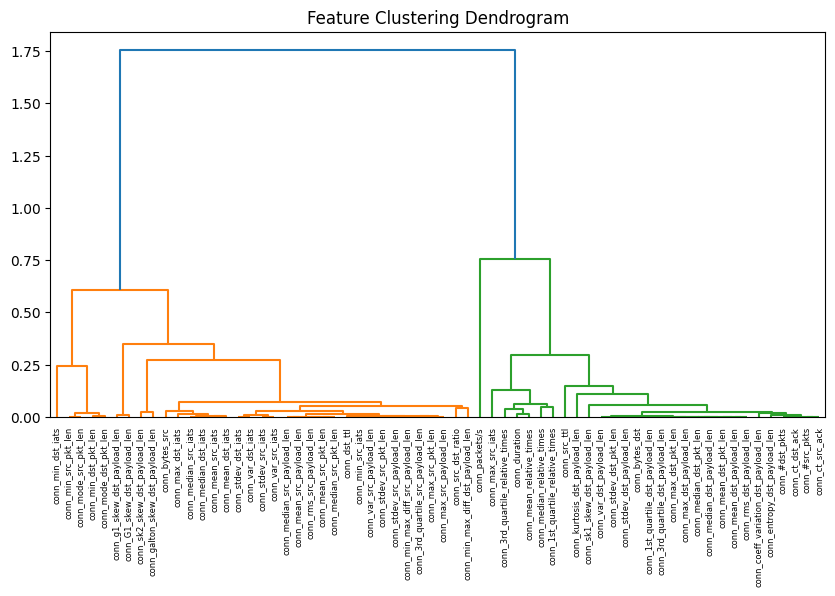


----- Host 2 -----


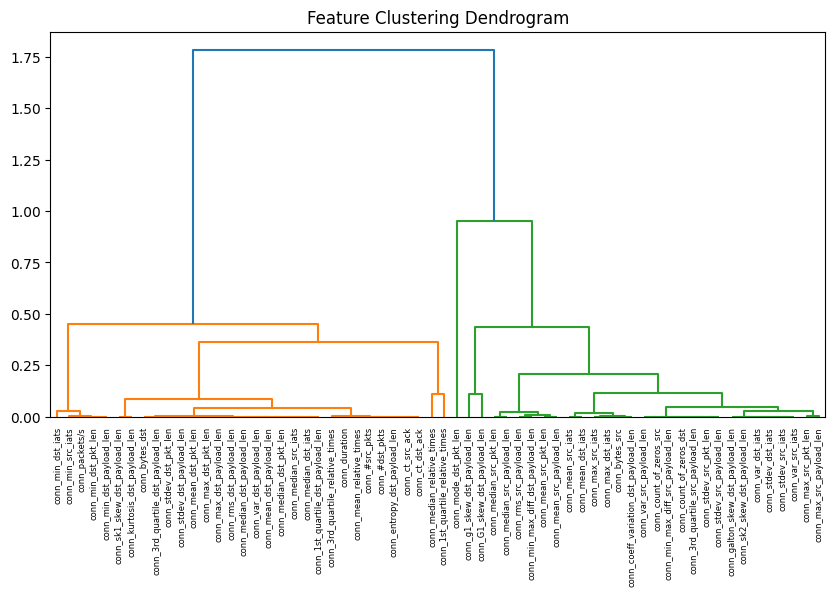


----- Host 3 -----
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
No correlation data for host 3!

----- Host 4 -----
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-Windows to compute correlation, skipping!
Not enough 10s-W

In [ ]:
import data_analysis.data_processing as d

# reload module to bypass caching
import importlib
importlib.reload(d)

# treat it as a long path to avoid path length issues
test_window_path = d.Path(r'\\?\C:\Users\jannis\Documents\HSP_IDS\Material\Aktuell\2025-02-17_11-14-33_192.168.1.0-normal_1\1554220324.748197-1554220354.748197')
test_window = d.ThirtySecWindow(test_window_path)
test_data_set_path = d.Path(r'\\?\C:\Users\jannis\Documents\HSP_IDS\Material\Aktuell\2025-02-17_11-14-33_192.168.1.0-normal_1')

d.time_series_kmeans(test_window)